# Compare Images by Color

Solution with KMeans Clustering for Image Colors and Coordinates, Distance between results calculated with Wasserstein Distance / Earth Movers Distance with weighted input

#### Import Libraries

In [115]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import seaborn as sb
import matplotlib.pyplot as plt

#### Some Variables

In [116]:
IMG_SIZE = (100,100)
CLUSTERS = 5
MIN_PIX_FOR_CLUSTER= 100
COLOR_WEIGHT = 100
POSITION_WEIGHT  = 50
ALPHA = 0.01

#### Import of Images

In [117]:
def load_images_from_folder(folder):
    """Lädt Bilder aus einem Ordner als BGR (OpenCV-Standard)."""
    images = {}
    for filename in os.listdir(folder):
        if filename.lower().endswith((".jpg", ".jpeg", ".png")):
            path = os.path.join(folder, filename)
            img = cv2.imread(path)  # BGR
            if img is not None:
                images[filename] = img
    return images

#### Methods for Image Preprocessing

In [118]:
def preprocess_image(img, target_size=IMG_SIZE):
    """Ensure imgs are all in same size and colorspace"""
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, target_size)
    return img_resized

#processed_images = {name: preprocess_image(img, target_size) for name, img in raw_images.items()}

#### KMeans Clustering

In [119]:
def kmeans_color_clustering(img, clusters=CLUSTERS, n_init = MIN_PIX_FOR_CLUSTER, spatial=False):
    """
    KMeans Clustering with one Image    
    - spatial=False: Clustering by Colors in image
    - spatial=True: Clustering by Colors in image incl. Positions

    Proposel for enhancement: 
    - check how far away from cluster center is the pixel, 
    - maybe calculate STD within each Cluster and then do sth with that 
    ( clusters with more then x distance are part of no Cluster or if STD is big this Cluster should have less impact)
    """
    h, w = IMG_SIZE
    img_norm = img / 255.0
    pixels = img_norm.reshape(-1, 3)

    if spatial:
        # Creeate Meshgrid to store Position information
        xx, yy = np.meshgrid(np.arange(w), np.arange(h))
        coords = np.stack((yy, xx), axis=-1).reshape(-1, 2) / np.array([h, w])
        features = np.concatenate([pixels, coords], axis=1)  # [R,G,B,Y,X]
    else:
        features = pixels  # [R,G,B]

    kmeans = KMeans(n_clusters=clusters, n_init=n_init)
    kmeans.fit(features)

    centers = kmeans.cluster_centers_
    counts = np.bincount(kmeans.labels_) / len(kmeans.labels_)

    result = np.hstack((centers, counts.reshape(-1, 1)))
    return result


#### Prepare CLuster Result for Comparison

In [120]:

def prepare_cluster_for_comparison(array, color_weight=COLOR_WEIGHT, position_weight=POSITION_WEIGHT):
    feature_dim = array.shape[1] - 1
    if feature_dim == 3:
        scaling = np.array([color_weight] * 3)
    elif feature_dim == 5:
        scaling = np.array([color_weight] * 3 + [position_weight] * 2)
    else:
        raise ValueError(f"Unerwartete Feature-Dimension: {feature_dim}")

    features = array[:, :feature_dim] * scaling
    weights = array[:, -1]
    return np.hstack([weights[:, np.newaxis], features]).astype(np.float32)

#### Wasserstein / Earth Movers Distance


In [121]:
def emd_distance(wheighted_clusters1, wheighted_clusters2):
    min_len = min(len(wheighted_clusters1), len(wheighted_clusters2))
    wc1 = wheighted_clusters1[:min_len]
    wc2 = wheighted_clusters2[:min_len]
    distance, lowerBound , flow  = cv2.EMD(wc1, wc2, cv2.DIST_L2)
    return distance

In [122]:
# # # For scaling between 0 and 1 - ChatGPT Proposal
def emd_similarity_score(distance, alpha=1.0):
    return np.exp(-alpha * distance)

# # EMD kann beliebig große Werte annehmen → kein natürliches Maximum
# # Aber: exp(-distance) ergibt immer einen Wert zwischen 0 und 1, wobei:
# # 1.0 = identisch
# # ~0.0 = sehr unähnlich
# # Der Parameter alpha steuert, wie steil der Abfall ist (z.B. alpha=0.05 für langsameren Abfall)

# Additional Visualisation methods (By ChatGPT)

just to show a little bit better what happens 

In [123]:
from sklearn.decomposition import PCA


def plot_clusters_in_2d(img, kmeans, sample_size=1000):
    """Zeigt die Farbverteilung und Clusterzentren in 2D (PCA auf RGB)"""
    
    X = img.reshape(-1, 3)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # Falls das Bild zu groß ist, Stichprobe nehmen
    if len(X) > sample_size:
        idx = np.random.choice(len(X), sample_size, replace=False)
        X_sample = X[idx]
        labels_sample = labels[idx]
    else:
        X_sample = X
        labels_sample = labels

    # PCA zur Projektion in 2D
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X_sample)
    centers_2d = pca.transform(centers)

    # Punkte plotten, eingefärbt nach RGB (original)
    plt.figure(figsize=(6, 6))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=X_sample / 255, s=10, alpha=0.6, label="Pixels")

    # Clusterzentren plotten
    plt.scatter(centers_2d[:, 0], centers_2d[:, 1], 
                c=centers / 255, edgecolor='black', 
                s=300, marker='X', label="Cluster Centers")

    plt.title("Farben im RGB-Raum (PCA auf 2D)")
    plt.axis("off")
    plt.legend()
    plt.show()


def visualize_kmeans(img, kmeans):
    """Visualisiert die Clusterfarben nach Häufigkeit und zeigt das segmentierte Bild."""
    h, w, _ = img.shape
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    # Clusterhäufigkeit ermitteln
    _, counts = np.unique(labels, return_counts=True)
    proportions = counts / counts.sum()

    # Balken-Visualisierung der Farben (nach Häufigkeit sortiert)
    sorted_idx = np.argsort(-proportions)
    sorted_colors = centers[sorted_idx]
    sorted_proportions = proportions[sorted_idx]

    # Erzeuge Farbbalken
    bar = np.zeros((50, 300, 3), dtype='uint8')
    start_x = 0
    for prop, color in zip(sorted_proportions, sorted_colors):
        end_x = start_x + int(prop * bar.shape[1])
        cv2.rectangle(bar, (start_x, 0), (end_x, bar.shape[0]), color.astype('uint8').tolist(), -1)
        start_x = end_x

    # Zeige die Farbbalken
    plt.figure(figsize=(10, 2))
    plt.imshow(bar)
    plt.axis('off')
    plt.title("Dominante Farben (nach Anteil)")
    plt.show()

    # Segmentiertes Bild anzeigen
    segmented_img = centers[labels].reshape((h, w, 3)).astype(np.uint8)
    plt.figure(figsize=(3, 3))
    plt.imshow(segmented_img)
    plt.axis('off')
    plt.title("Segmentiertes Bild")
    plt.show()

def show_similarity_heatmap(df_similarity):
    df_plot = df_similarity.set_index("Compared_with")
    plt.figure(figsize=(10, 8))
    sb.heatmap(df_plot, annot=True, fmt=".2f", cmap="YlGn")
    plt.title("Image Similarity Heatmap")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


# Main with 2 Images incl. Visualisation

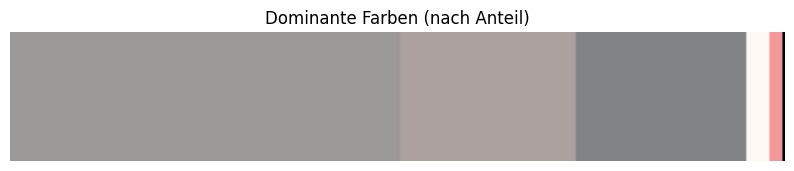

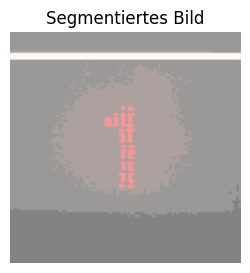

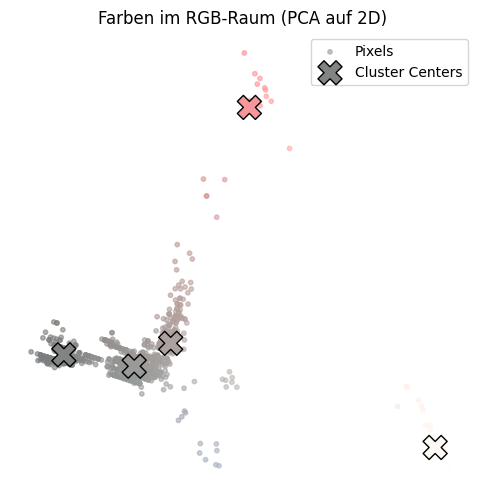

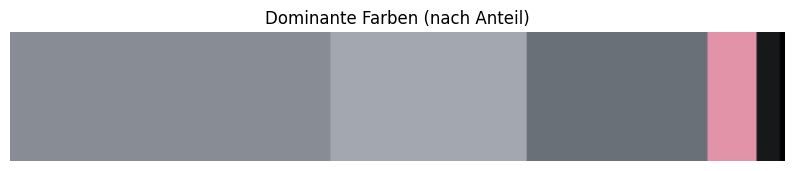

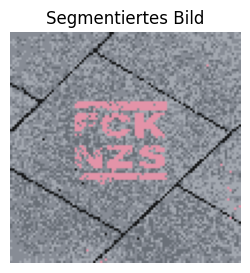

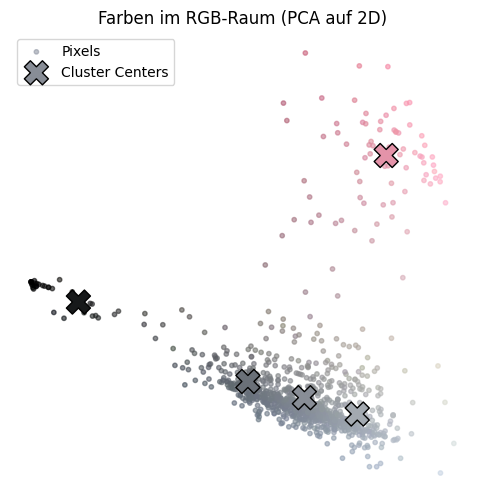

EMD Distance between '1.jpg' and '2.jpg': 11.1576
Similarity Score (exp(-dist)): 0.8944


In [ ]:

folder = os.path.join(os.getcwd(), "..", "expImg")
images = load_images_from_folder(folder)
processed_images = {name: preprocess_image(img, IMG_SIZE) for name, img in images.items()}

image_names = list(processed_images.keys())
img1 = processed_images[image_names[0]]
img2 = processed_images[image_names[1]]

# Clustering
res1 = kmeans_color_clustering(img1, CLUSTERS, MIN_PIX_FOR_CLUSTER, spatial=True)
res2 = kmeans_color_clustering(img2, CLUSTERS, MIN_PIX_FOR_CLUSTER, spatial=True)

# Vis
kmeans1 = KMeans(n_clusters=CLUSTERS, n_init=MIN_PIX_FOR_CLUSTER)
kmeans1.fit(img1.reshape(-1, 3))
visualize_kmeans(img1, kmeans1)
plot_clusters_in_2d(img1, kmeans1)

kmeans2 = KMeans(n_clusters=CLUSTERS, n_init=MIN_PIX_FOR_CLUSTER)
kmeans2.fit(img2.reshape(-1, 3))
visualize_kmeans(img2, kmeans2)
plot_clusters_in_2d(img2, kmeans2)

# prepare for comparison
wc1 = prepare_cluster_for_comparison(res1)
wc2 = prepare_cluster_for_comparison(res2)

# calculate EMD 
dist = emd_distance(wc1, wc2)
sim = emd_similarity_score(dist, alpha=ALPHA)

print(f"EMD Distance between '{image_names[0]}' and '{image_names[1]}': {dist:.4f}")
print(f"Similarity Score (exp(-dist)): {sim:.4f}")


# Main With All Images in Folder + Heatmap

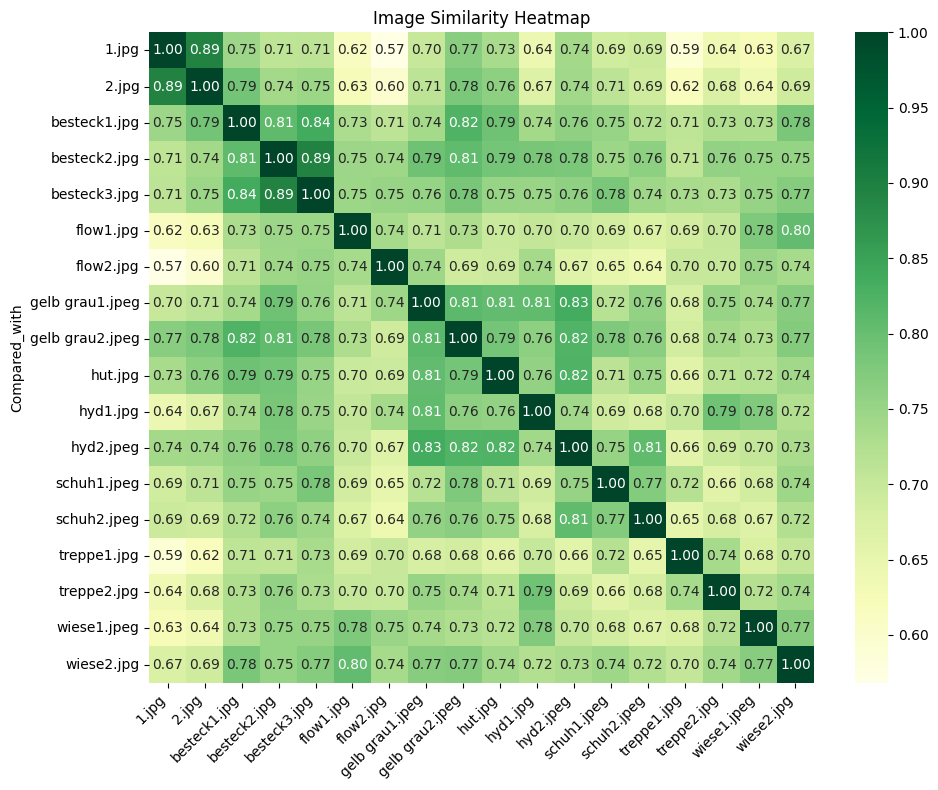

In [ ]:
# Prepare images + Clustering
clustered_data = {}
for name, img in processed_images.items():
    res = kmeans_color_clustering(img, CLUSTERS, MIN_PIX_FOR_CLUSTER, spatial=True)
    clustered_data[name] = prepare_cluster_for_comparison(res)

# Calculate Similarity score for each pair
similarity_matrix = pd.DataFrame(index=clustered_data.keys(), columns=clustered_data.keys(), dtype=float)

for name1, wc1 in clustered_data.items():
    for name2, wc2 in clustered_data.items():
        dist = emd_distance(wc1, wc2)
        similarity_matrix.loc[name1, name2] = emd_similarity_score(dist, alpha=ALPHA)  # optional: similarity statt distance

# Create Heatmap
similarity_matrix.insert(0, "Compared_with", similarity_matrix.index)
show_similarity_heatmap(similarity_matrix)


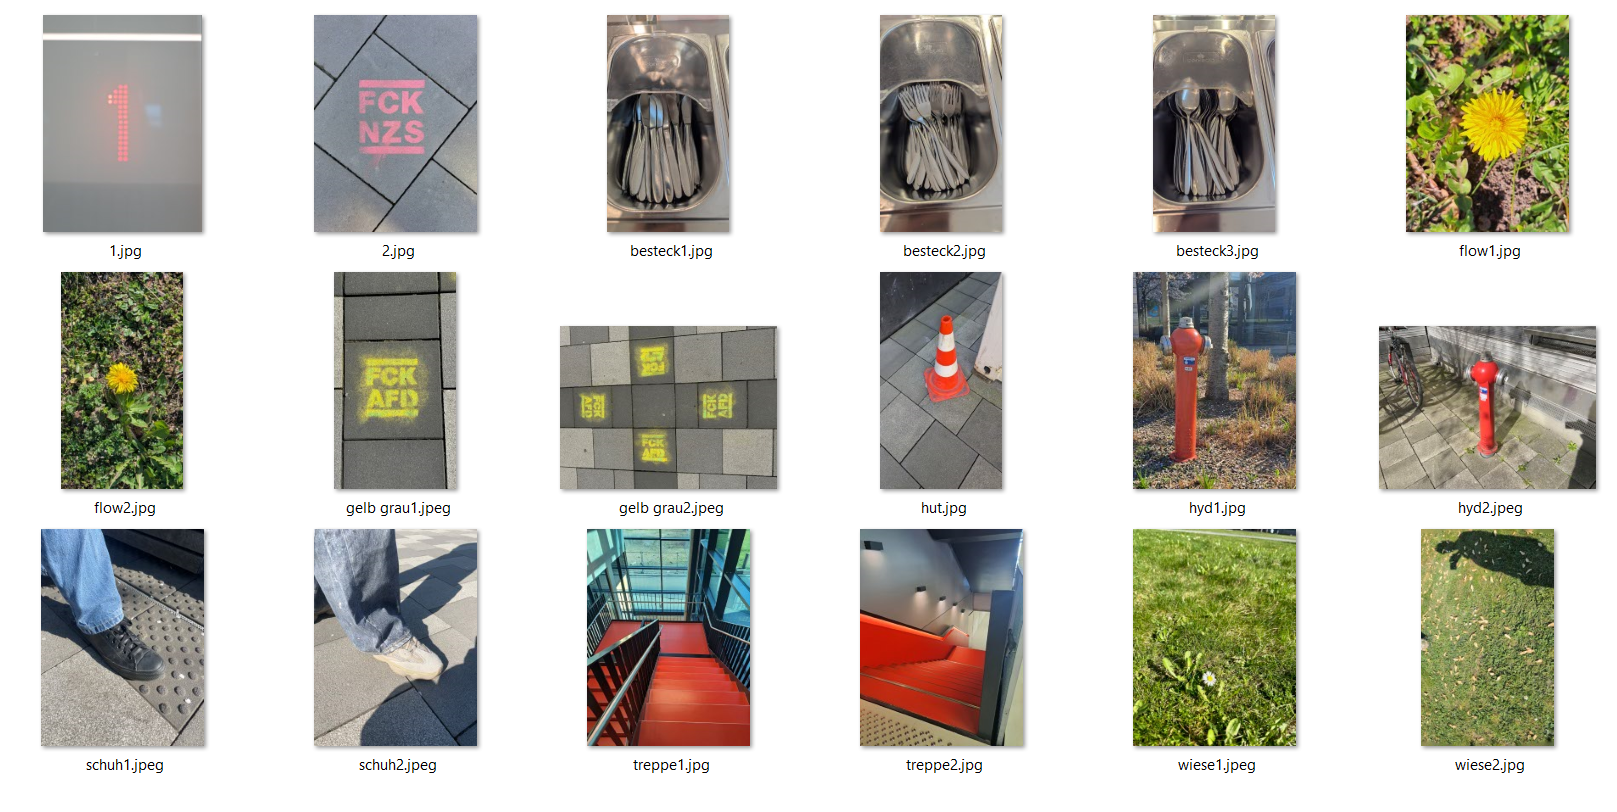